In [1]:
%cd ..
%pip install -e .

/home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
Obtaining file:///home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
  Preparing metadata (setup.py) ... done
  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random

import numpy as np
import pandas as pd

from src.models.dense import NN0
from src.models.dense import NN1
from src.models.gcn import GCN0
from src.models.gcn import GCN1
from src.models.gat import GAT

from src.models.train_model import train_with_loss
from src.models.train_model import random_splits

from src.models.reg import make_preg_ce_ce
from src.models.reg import make_lap_loss_ce_alt

from src.models.reg import compute_a_hat

from src.models.evaluate_model import evaluate0
from src.models.evaluate_model import evaluate1

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from sklearn.manifold import TSNE

from src.models.evaluate_model import test
from tqdm import tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0].to(device)

A_hat = compute_a_hat(data)

# data = random_splits(data, 50, 20)
data.reg_mask = torch.ones_like(data.train_mask, dtype=torch.bool)


In [4]:
print('-------------------------------------------------------------')
print(f'train size: {data.train_mask.sum()}')
print(f'val size: {data.val_mask.sum()}')
print(f'test size: {data.test_mask.sum()}')
print('-------------------------------------------------------------')

metrics = []

for loss_fn_name in ['lap_loss', 'preg_loss']:
    for model_name in ['gcn', 'gat']:
        for mu in range(9):
            torch.manual_seed(1)
            random.seed(1)

            mu = mu / 10

            if loss_fn_name == 'lap_loss':
                loss_fn = make_lap_loss_ce_alt(mu)
            elif loss_fn_name == 'preg_loss':
                loss_fn = make_preg_ce_ce(mu, A_hat)
            else:
                raise(Exception('Not Implemented'))
            
            if model_name == 'gcn':
                model = GCN1(num_node_features=dataset.num_node_features,
                    num_classes=dataset.num_classes) \
                    .to(device)
            elif model_name == 'gat':
                model = GAT(dataset=dataset).to(device)
            else:
                raise(Exception('Not Implemented'))


            model = train_with_loss(model, data, loss_fn, num_epochs=200)

            acc = evaluate0(model, data)

            train_acc, val_acc, test_acc = evaluate1(model, data)
            metrics.append({'model': model_name, 'reg': loss_fn_name, 'mu': mu, 'train_acc': np.round(train_acc,4), 'val_acc': np.round(val_acc,4), 'test_acc': np.round(test_acc,4)})
            print(metrics[-1])
            # print(f'mu: {mu}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, test_acc: {test_acc:.4f}')
            # print('-------------------------------------------------------------')


-------------------------------------------------------------
train size: 140
val size: 500
test size: 1000
-------------------------------------------------------------
tensor(272.3325, grad_fn=<NllLossBackward0>)
tensor(1.2771, grad_fn=<SumBackward0>)
----
tensor(271.6046, grad_fn=<NllLossBackward0>)
tensor(16.5507, grad_fn=<SumBackward0>)
----
tensor(270.4776, grad_fn=<NllLossBackward0>)
tensor(42.6649, grad_fn=<SumBackward0>)
----
tensor(269.3994, grad_fn=<NllLossBackward0>)
tensor(90.3818, grad_fn=<SumBackward0>)
----
tensor(268.3596, grad_fn=<NllLossBackward0>)
tensor(145.4254, grad_fn=<SumBackward0>)
----
tensor(266.8752, grad_fn=<NllLossBackward0>)
tensor(237.0965, grad_fn=<SumBackward0>)
----
tensor(266.1448, grad_fn=<NllLossBackward0>)
tensor(319.9919, grad_fn=<SumBackward0>)
----
tensor(264.4764, grad_fn=<NllLossBackward0>)
tensor(453.5517, grad_fn=<SumBackward0>)
----
tensor(262.9398, grad_fn=<NllLossBackward0>)
tensor(616.7781, grad_fn=<SumBackward0>)
----
tensor(261.0792,

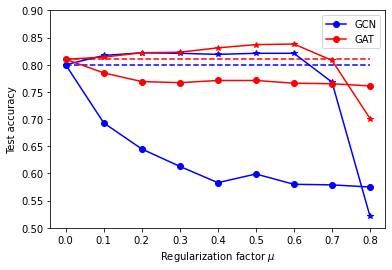

In [8]:
df = pd.DataFrame(metrics)
df.to_csv('reports/figures/fig2c_alt.csv')
fig, ax = plt.subplots()

filt = (df['model'] == 'gcn') & (df['reg'] == 'preg_loss')
ax.plot(df[filt]['mu'], 9*[df[filt]['test_acc'][df[filt]['mu']==0]], '--b')

filt = (df['model'] == 'gat') & (df['reg'] == 'preg_loss')
ax.plot(df[filt]['mu'], 9*[df[filt]['test_acc'][df[filt]['mu']==0]], '--r')

filt = (df['model'] == 'gcn') & (df['reg'] == 'preg_loss')
ax.plot(df[filt]['mu'], df[filt]['test_acc'], '-*b')

filt = (df['model'] == 'gat') & (df['reg'] == 'preg_loss')
ax.plot(df[filt]['mu'], df[filt]['test_acc'], '-*r')

filt = (df['model'] == 'gcn') & (df['reg'] == 'lap_loss')
ax.plot(df[filt]['mu'], df[filt]['test_acc'], '-ob', label='GCN')

filt = (df['model'] == 'gat') & (df['reg'] == 'lap_loss')
ax.plot(df[filt]['mu'], df[filt]['test_acc'], '-or', label='GAT')

ax.set(ylim=(.5, .9), xlabel='Regularization factor $\mu$', ylabel='Test accuracy')
ax.legend()
plt.show()

In [ ]:
dataset.num_classes

7